### [Introduction](#Introduction)

> As telecom brands are the data providers of all online activities, meeting user
requirements, and creating an engaging user experience is a prerequisite for them.
Building & improving the QoS (Quality of Service) to leverage the mobile platforms and
to get more users for the business is good but the success of the business would be
determined by the user engagement and activity of the customers on available apps.


### Objective

> Determine the level of engagement of a random user for
  any application
  
  - #### Track the user’s engagement using
    - ##### sessions frequency
    - ##### the duration of the session
    - ##### sessions total traffic (download and upload (bytes))

### Research Question

1. Aggregate the above metrics per customer id (MSISDN) and report the top 10
   customers per engagement metric - (jupyter notebook + slide for top 10)
2. Normalize each engagement metric and run a k-means (k=3) to classify
   customers in three groups of engagement. - (jupyter notebook)
3. Compute the minimum, maximum, average & total non- normalized metrics for
   each cluster. Interpret your results visually with accompanying text. - (jupyter
   notebook + slide)
4. Aggregate user total traffic per application and derive the top 10 most engaged
   users per application - (jupyter notebook + slide)
5. Plot the top 3 most used applications. - (jupyter notebook + slide)
6. Using k- means clustering algorithm, group users in k engagement clusters based
   on the engagement metrics:
   - What is the optimized value of k ? - (slide)
   - Interpret your findings. - (slide)


### Import all necessary libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action = 'ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [5]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

### Read data from the data folder 

In [6]:
data = pd.read_excel('data/Week2_challenge_data_source.xlsx')

### Save features into categorical and numerical list

In [7]:
categorical_features = []
numerical_features = []
datetime_feature = []

feature = data.columns.to_series().groupby(data.dtypes).groups
for name , value in feature.items():
    if name.name == 'object':
        categorical_features.append(value)
    elif name.name in ['int64','int32','float64','float32']:
        numerical_features.append(value)
    elif name.name == 'datetime64[ns]':
        datetime_feature.append(value)

### Check the proportion of null values

In [8]:
numerical_data = data[numerical_features[0]]

In [9]:
a = numerical_data.isna().sum() / len(numerical_data)

high_missing_value_feature_names = []
for name, value in a.to_dict().items():
    if value > 0.01:
        high_missing_value_feature_names.append(name)
        
high_missing_value_feature_names

['Nb of sec with 37500B < Vol UL',
 'Nb of sec with 31250B < Vol DL < 125000B',
 'Nb of sec with 125000B < Vol DL',
 'TCP DL Retrans. Vol (Bytes)',
 'TCP UL Retrans. Vol (Bytes)',
 'Nb of sec with 6250B < Vol UL < 37500B',
 'Avg RTT UL (ms)',
 'HTTP DL (Bytes)',
 'Avg RTT DL (ms)',
 'Nb of sec with 6250B < Vol DL < 31250B',
 'Nb of sec with 1250B < Vol UL < 6250B',
 'HTTP UL (Bytes)']

In [10]:
# function to check if a value is a string object
# returns a boolean value True --> if its a string   False --> if its not a string object

def is_str(s):
    a = isinstance(s,str)
    return a

In [11]:
"""
remove rows with empty strings and missing values
MSISDN/Number is a unique identifier to users and 
null entries cannot be imputed with mode/mean/median

using mode would skew the the data to a particular user
during modelling and other exploratory analysis

"""

data.drop(data.loc[data['Bearer Id'].apply(is_str)].index, inplace = True)

data.drop(data.loc[data['MSISDN/Number'].isna()].index, inplace = True)

In [12]:
# create a new column which is the addition of total download and total upload
data['Total Data Volume'] = data['Total DL (Bytes)'].add(data['Total UL (Bytes)'])

data['Social_media Data Volume'] = data['Social Media DL (Bytes)'].add(data['Social Media UL (Bytes)'])
data['Google Data Volume'] = data['Google DL (Bytes)'].add(data['Google UL (Bytes)'])
data['Email Data Volume'] = data['Email DL (Bytes)'].add(data['Email UL (Bytes)'])
data['Youtube Data Volume'] = data['Youtube DL (Bytes)'].add(data['Youtube UL (Bytes)'])
data['Netflix Data Volume'] = data['Netflix DL (Bytes)'].add(data['Netflix UL (Bytes)'])
data['Gaming Data Volume'] = data['Gaming DL (Bytes)'].add(data['Gaming UL (Bytes)'])
data['Other Data Volume'] = data['Other DL (Bytes)'].add(data['Other UL (Bytes)'])

In [43]:
data2 = data[['MSISDN/Number','Bearer Id','Dur. (ms).1','Total UL (Bytes)','Total DL (Bytes)','Social_media Data Volume','Google Data Volume',\
                'Other Data Volume', 'Email Data Volume','Youtube Data Volume', 'Netflix Data Volume', \
                'Gaming Data Volume','Total Data Volume']]

In [132]:
#d = data2.groupby(['MSISDN/Number']).apply(agg_eng)

In [193]:
# converts values from bytes to megabytes

def bytes_to_megabytes(num):
    if not isinstance(num, str):
        mb = 1024 ** 2
        return float('{0:.2f}'.format(num/mb))
    else:
        return num

#### Convert MSISDN/Number to string so that its plotted as a categorical variable

In [37]:
data['MSISDN/Number'] = data['MSISDN/Number'].astype('str')

## Track User Engagement:



#### Session Frequency

In [202]:
# Aggregates per user 

sess_freq = data2.groupby(['MSISDN/Number']).agg({'Dur. (ms).1':'sum','Bearer Id':'count','Total Data Volume':'sum'}).reset_index()

In [203]:
# sort the values in descending order
sorted_sess_freq_dur = sess_freq[['MSISDN/Number','Dur. (ms).1']].sort_values(by = 'Dur. (ms).1', ascending = False)

In [234]:
sorted_sess_freq_dur.head(10)

,MSISDN/Number,Dur. (ms).1
13124,33625779332.0,1.855376e+10
6405,33614892860.0,9.966906e+09
92586,33760536639.0,9.279442e+09
13468,33626320676.0,8.791937e+09
64884,33667163239.0,8.744922e+09
50097,33662840755.0,6.614274e+09
56952,33664693736.0,6.288736e+09
659,33603127838.0,6.287767e+09
65788,33667456716.0,5.649885e+09
92241,33760413819.0,5.321674e+09


In [205]:
# sort values in descending order
sorted_sess_freq_sess = sess_freq[['MSISDN/Number','Bearer Id']].sort_values(by = 'Bearer Id', ascending = False)

In [236]:
sorted_sess_freq_sess.head(10)

,MSISDN/Number,Bearer Id
13468,33626320676.0,18
13124,33625779332.0,17
6405,33614892860.0,17
36910,33659725664.0,16
92586,33760536639.0,15
76078,33675877202.0,15
64884,33667163239.0,13
105758,33786323068.0,12
1271,33604515716.0,12
92241,33760413819.0,12


In [207]:
# sort values in descending order
sorted_sess_freq_data = sess_freq[['MSISDN/Number','Total Data Volume']].sort_values(by = 'Total Data Volume', ascending = False)

In [238]:
sorted_sess_freq_data.head(10)

,MSISDN/Number,Total Data Volume
6405,33614892860.0,8.846226e+09
92586,33760536639.0,8.514774e+09
13124,33625779332.0,8.499621e+09
13468,33626320676.0,7.971167e+09
76078,33675877202.0,7.891111e+09
36910,33659725664.0,7.705863e+09
62805,33666464084.0,7.308501e+09
92241,33760413819.0,7.132371e+09
57033,33664712899.0,6.872018e+09
86139,33698792269.0,6.540899e+09


In [208]:
# merge engagement metrics together
# merge all dataframe into a single dataframe named engaged df

In [211]:
# sort engaged_df values in descending order
engaged_df = sorted_sess_freq_dur.merge(sorted_sess_freq_sess , on = 'MSISDN/Number').merge(sorted_sess_freq_data, on = 'MSISDN/Number')

In [212]:
# convert engaged df values from bytes to megabytes so that can be well visualised
engaged_df_mb = engaged_df[['MSISDN/Number','Total Data Volume','Dur. (ms).1']].applymap(bytes_to_megabytes)

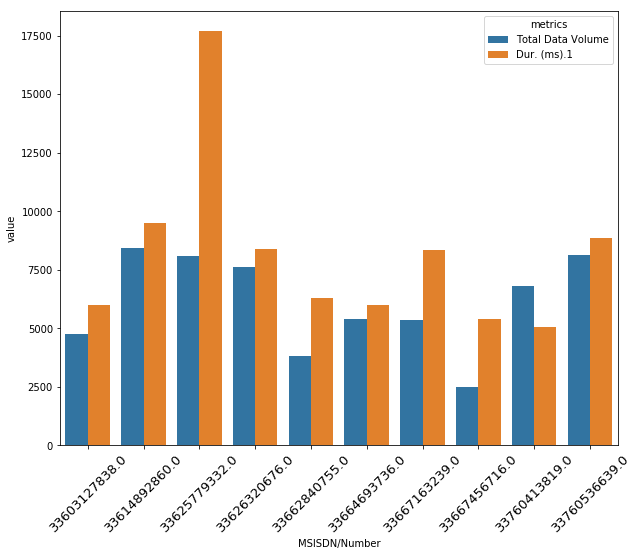

In [213]:
# MELT The dataframe to create a categorical column of containing engagement metrics

eng = pd.melt(id_vars=['MSISDN/Number'], value_vars=['Total Data Volume','Dur. (ms).1'],
        value_name='value', var_name='metrics', frame=engaged_df_mb.head(10))

plt.figure(figsize = (10,8))
sns.barplot(data = eng , x = 'MSISDN/Number',y = 'value', hue = 'metrics')
plt.xticks(rotation=45, fontsize=13)
plt.show()

## Normalize and Kmeans

In [55]:
data_norm = data2[['Bearer Id','Total Data Volume','Dur. (ms).1']]

In [56]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_norm)

In [57]:
kmean = KMeans(n_clusters=2, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=0)

In [58]:
km_data = kmean.fit_predict(data_scaled)

#### Plot the Clusters

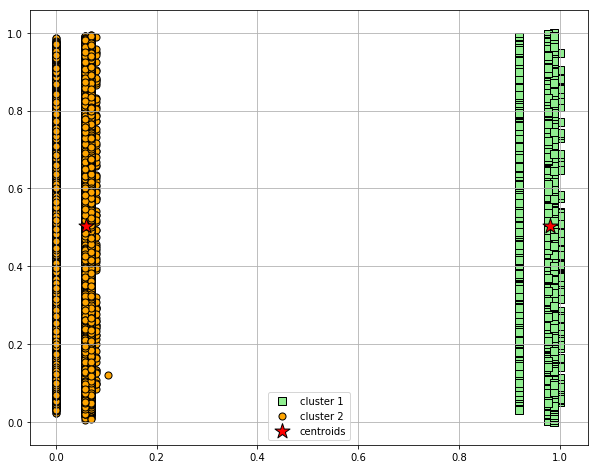

In [62]:
# plot the 3 clusters
plt.figure(figsize = (10,8))

plt.scatter(
    data_scaled[km_data == 0, 0], data_scaled[km_data == 0, 1],
    s=50, c='lightgreen',
    marker='s', edgecolor='black',
    label='cluster 1'
)

plt.scatter(
    data_scaled[km_data == 1, 0], data_scaled[km_data == 1, 1],
    s=50, c='orange',
    marker='o', edgecolor='black',
    label='cluster 2'
)

# plot the centroids
plt.scatter(
    kmean.cluster_centers_[:, 0], kmean.cluster_centers_[:, 1],
    s=250, marker='*',
    c='red', edgecolor='black',
    label='centroids'
)

plt.legend(scatterpoints=1)
plt.grid()
plt.show()


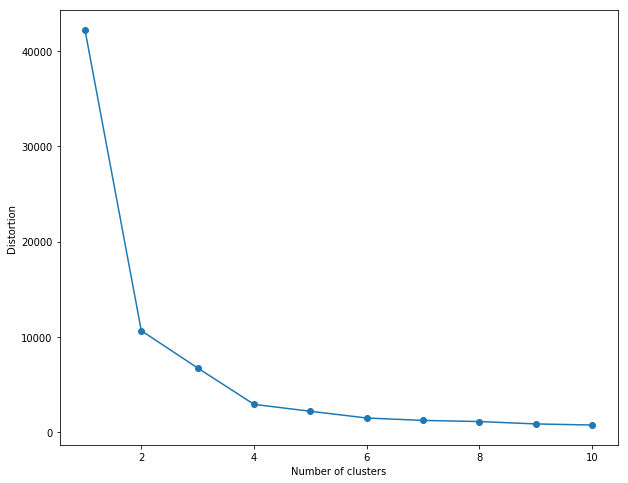

In [63]:
distortions = []
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(data_scaled)
    distortions.append(km.inertia_)

# plot
plt.figure(figsize = (10,8))
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

### minimum, maximum, average & total non- normalized metrics for each cluster.

In [214]:
# crates a column named cluster that contains the cluster values
data_norm['cluster'] = km_data

In [215]:
#data_norm.head()

In [216]:
# aggregates per cluster the session duration 
session_duration_per_cluster = data_norm.groupby('cluster')['Dur. (ms).1'].aggregate(['min', 'max', 'mean', 'sum']).reset_index(drop=True)

In [76]:
# log the values transforming the values for proper visualisation
session_duration_per_cluster_mb = session_duration_per_cluster.applymap(np.log)

<Figure size 720x576 with 0 Axes>

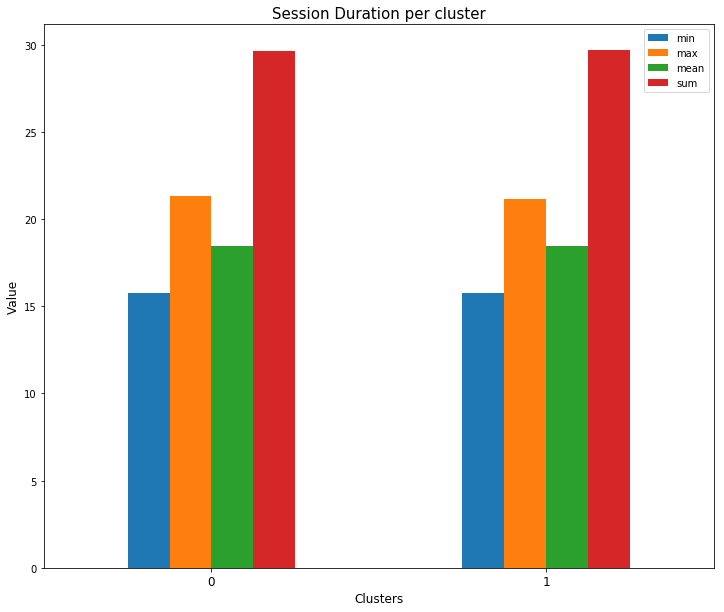

In [239]:
plt.figure(figsize = (10,8))
ax= session_duration_per_cluster_mb.plot.bar(figsize=(12,10))
plt.title("Session Duration per cluster", fontsize=15)
plt.xlabel('Clusters', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.xticks( rotation = 0,fontsize=12)
plt.savefig('fig/min_max.png')
plt.show()

#### Aggregate User Total Application Traffic

In [217]:
at = data2[['Social_media Data Volume','Google Data Volume',\
      'Other Data Volume', 'Email Data Volume','Youtube Data Volume', 'Netflix Data Volume', \
        'Gaming Data Volume','MSISDN/Number']].groupby('MSISDN/Number').sum().reset_index()

In [218]:
# converts bytes values to megabytes

at = at.applymap(bytes_to_megabytes)

In [104]:
google = at[['MSISDN/Number','Google Data Volume']].sort_values(by = 'Google Data Volume', ascending = False).head(10)

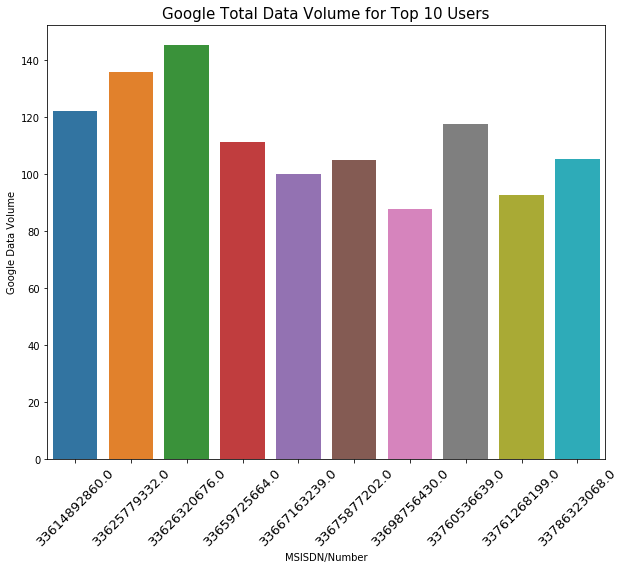

In [240]:
plt.figure(figsize = (10,8))
sns.barplot(data = google , x = 'MSISDN/Number',y = 'Google Data Volume')
plt.xticks(rotation=45, fontsize=13)
plt.title("Google Total Data Volume for Top 10 Users", fontsize=15)
plt.savefig('fig/google.png')
plt.show()

In [107]:
social = at[['MSISDN/Number','Social_media Data Volume']].sort_values(by = 'Social_media Data Volume', ascending = False).head(10)

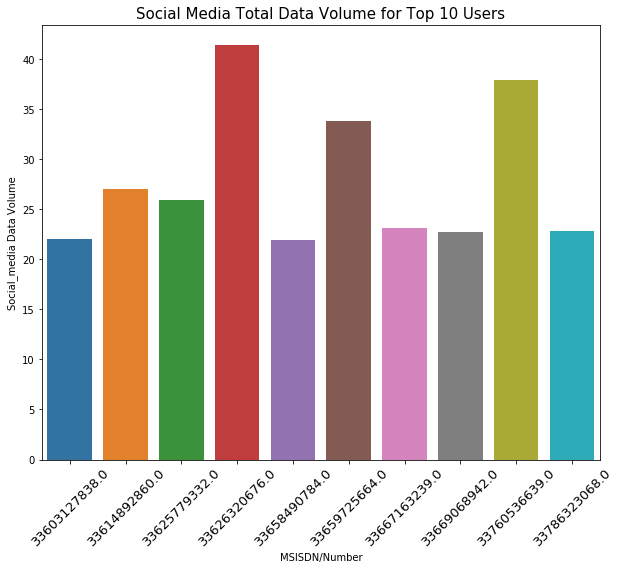

In [241]:
plt.figure(figsize = (10,8))
sns.barplot(data = social , x = 'MSISDN/Number',y = 'Social_media Data Volume')
plt.xticks(rotation=45, fontsize=13)
plt.title("Social Media Total Data Volume for Top 10 Users", fontsize=15)
plt.savefig('fig/social.png')
plt.show()

In [109]:
Netflix = at[['MSISDN/Number','Netflix Data Volume']].sort_values(by = 'Netflix Data Volume', ascending = False).head(10)

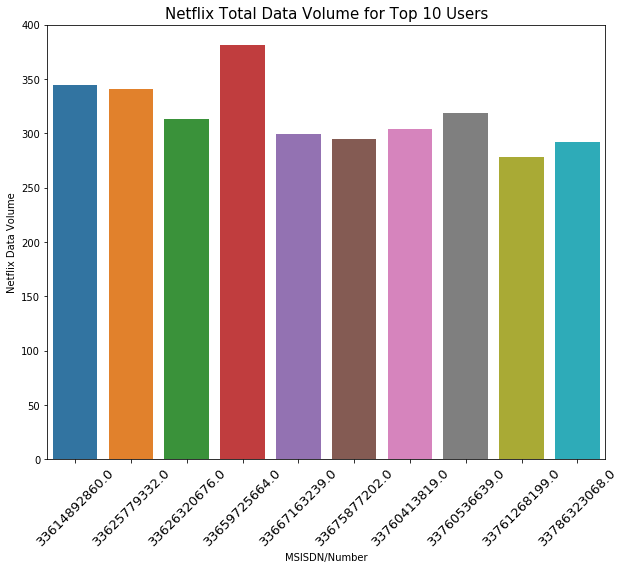

In [242]:
plt.figure(figsize = (10,8))
sns.barplot(data = Netflix , x = 'MSISDN/Number',y = 'Netflix Data Volume')
plt.xticks(rotation=45, fontsize=13)
plt.title("Netflix Total Data Volume for Top 10 Users", fontsize=15)
plt.savefig('fig/netflix.png')
plt.show()

In [111]:
Other = at[['MSISDN/Number','Other Data Volume']].sort_values(by = 'Other Data Volume', ascending = False).head(10)

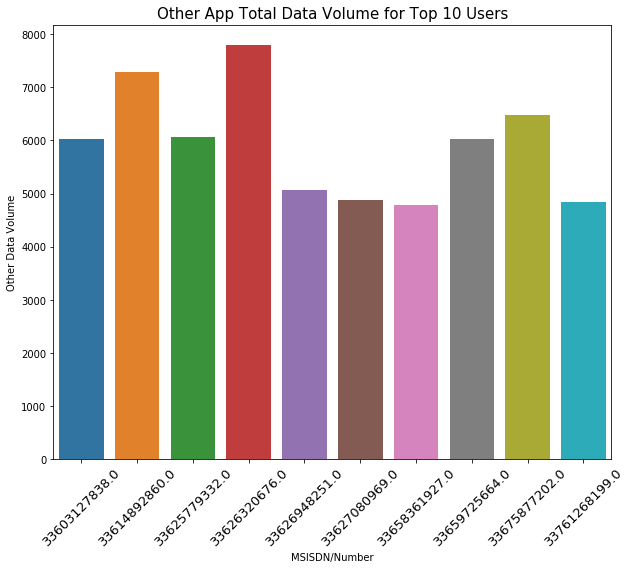

In [243]:
plt.figure(figsize = (10,8))
sns.barplot(data = Other , x = 'MSISDN/Number',y = 'Other Data Volume')
plt.xticks(rotation=45, fontsize=13)
plt.title("Other App Total Data Volume for Top 10 Users", fontsize=15)
plt.savefig('fig/other.png')
plt.show()

In [113]:
Email = at[['MSISDN/Number','Email Data Volume']].sort_values(by = 'Email Data Volume', ascending = False).head(10)

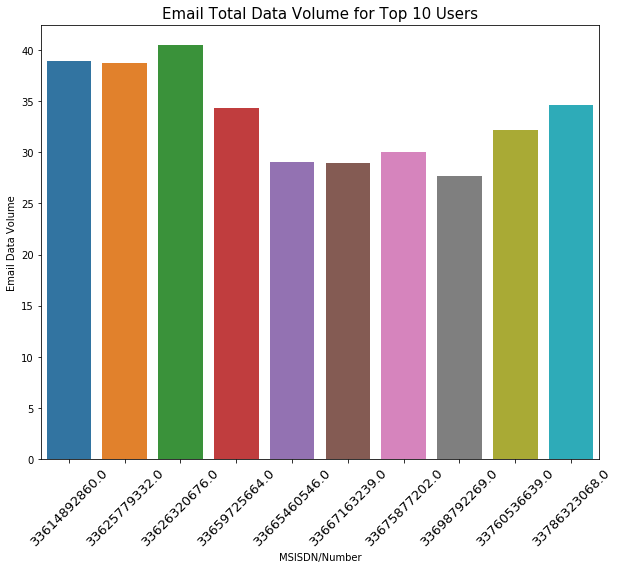

In [244]:
plt.figure(figsize = (10,8))
sns.barplot(data = Email , x = 'MSISDN/Number',y = 'Email Data Volume')
plt.xticks(rotation=45, fontsize=13)
plt.title("Email Total Data Volume for Top 10 Users", fontsize=15)
plt.savefig('fig/email.png')
plt.show()

In [116]:
Youtube = at[['MSISDN/Number','Youtube Data Volume']].sort_values(by = 'Youtube Data Volume', ascending = False).head(10)

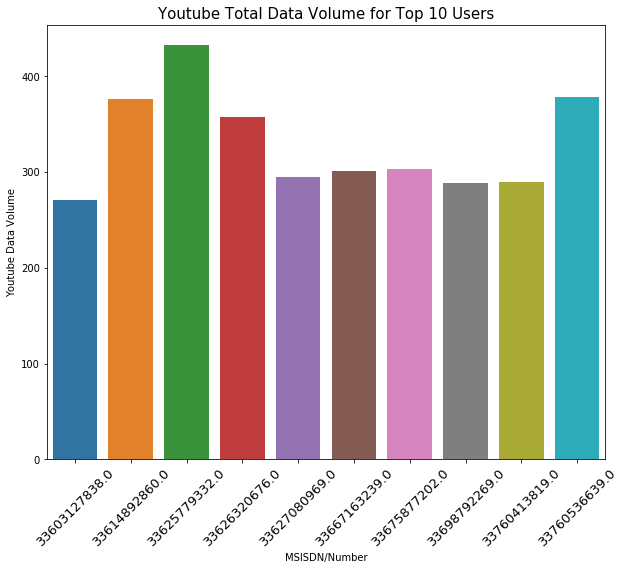

In [245]:
plt.figure(figsize = (10,8))
sns.barplot(data = Youtube , x = 'MSISDN/Number',y = 'Youtube Data Volume')
plt.xticks(rotation=45, fontsize=13)
plt.title("Youtube Total Data Volume for Top 10 Users", fontsize=15)
plt.savefig('fig/youtube.png')
plt.show()

In [118]:
Gaming = at[['MSISDN/Number','Gaming Data Volume']].sort_values(by = 'Gaming Data Volume', ascending = False).head(10)

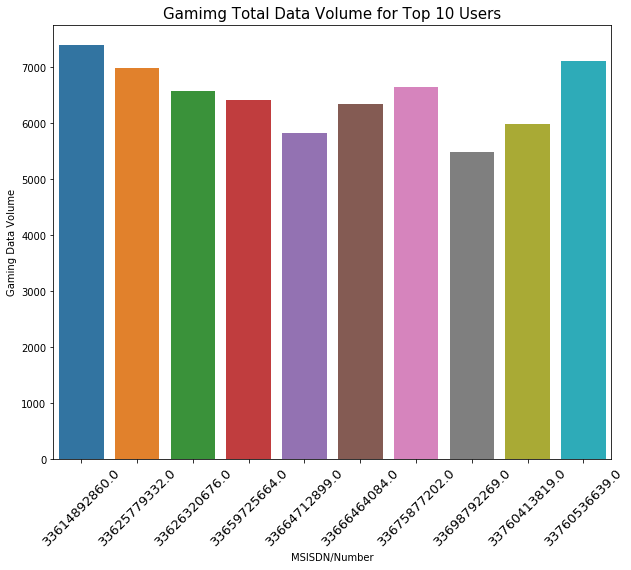

In [230]:
plt.figure(figsize = (10,8))
sns.barplot(data = Gaming , x = 'MSISDN/Number',y = 'Gaming Data Volume')
plt.xticks(rotation=45, fontsize=13)
plt.title("Gamimg Total Data Volume for Top 10 Users", fontsize=15)
plt.show()

### Top 3 App

In [231]:
s = at.apply(np.max)

In [232]:
s = s[1 :].sort_values(ascending = False).reset_index()
s.columns =  ['Application', 'Total data Usage in mb']
#df = pd.DataFrame(s[:3], columns = ['Application', 'Total data Usage in mb']) 

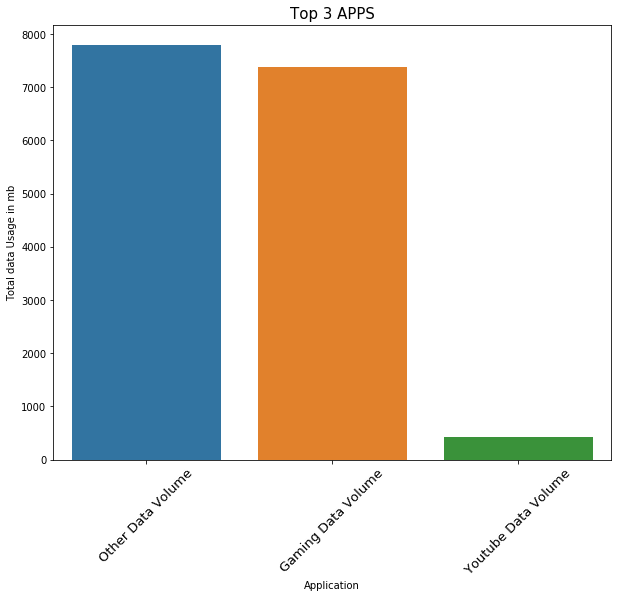

In [246]:
plt.figure(figsize = (10,8))
sns.barplot(data = s[:3] , x = 'Application',y = 'Total data Usage in mb')
plt.xticks(rotation=45, fontsize=13)
plt.title("Top 3 APPS", fontsize=15)
plt.savefig('fig/top3.png')
plt.show()

In [ ]:
#at[['MSISDN/Number','Google Data Volume']].sort_values(by = 'Google Data Volume', ascending = False).head(10)

In [167]:
data_norm.head()

,Bearer Id,Total Data Volume,Dur. (ms).1,cluster
0,13114483460844900352,345629377.0,1.823653e+09,0
1,13114483482878900224,707185356.0,1.365104e+09,0
2,13114483484080500736,307690973.0,1.361763e+09,0
3,13114483485442799616,889352748.0,1.321510e+09,0
4,13114483499480700928,607681403.0,1.089009e+09,0


In [190]:
df_0 = data_norm.loc[data_norm['cluster'] == 0]

In [186]:
df_1 = data_norm.loc[data_norm['cluster'] == 1]